In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def moon(x, y, tilt, phase):
    if phase > 29.5 / 2:
        tilt += 180
    tilt_rad = tilt * np.pi / 180
    x_ = x * np.cos(-tilt_rad) - y * np.sin(-tilt_rad)
    y_ = x * np.sin(-tilt_rad) + y * np.cos(-tilt_rad)
    base = 0.25 * (x_**2 + y_**2 < 15.5**2)
    coeff = np.cos(phase * 2 * np.pi / 29.5 + np.pi)
    bright = 0.75 * (-coeff * np.sqrt(15.5**2 - y_**2) < x_)
    bright *= (x_**2 + y_**2 < 15.5**2)
    return base + bright

In [3]:
#############################
phase = 15 # 0 - 29.5 (days)
tilt = 0 # deg
offset_list = [0, 5, 10, 15]
#############################

In [4]:
offset_dict = {}
for offset in offset_list:
    offset_dict[f"{offset:02d}"] = offset

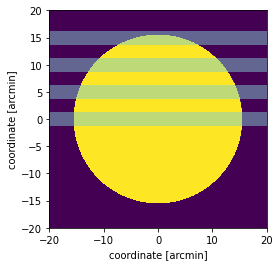

In [5]:
x = np.linspace(-20, 20, 1000)
y = np.linspace(-20, 20, 1000)
X, Y = np.meshgrid(x, -y)
Zmoon = moon(X, Y, tilt, phase)
fig = plt.figure()
ax = fig.add_subplot(111)
# coordinate relative to the center of the moon
ax.imshow(Zmoon, extent=(-20,20,-20,20), aspect="equal", interpolation="nearest", vmax=1)
[ax.plot(x, 0*x+offset, color=(0.5, 0.8, 0.8), lw=14, alpha=0.5) for offset in offset_list]
ax.set_xlabel("coordinate [arcmin]")
ax.set_ylabel("coordinate [arcmin]")
# plt.savefig(f"sim_moon_scanned_p{phase:02d}_t{tilt:03d}.pdf")
plt.show()

In [6]:
def beam(x, y, dx, dy):
    FWHM = 2.6
    c = FWHM / 2 / np.sqrt(2 * np.log(2))
    a = 1 / 2 / c**2
    return np.exp(-a * ((x-dx)**2 + (y-dy)**2))

In [7]:
def conv_2d(x, y):
    d = np.linspace(-5.2, 5.2, 260)
    x_ = np.array([d]*260)
    X = x + x_
    y_ = x_.T * [-1]
    Y = y + y_
    array_moon = moon(X, Y, tilt, phase)
    array_beam = beam(X, Y, x, y)
    moon_observed = sum(sum(array_moon * array_beam))
    return moon_observed

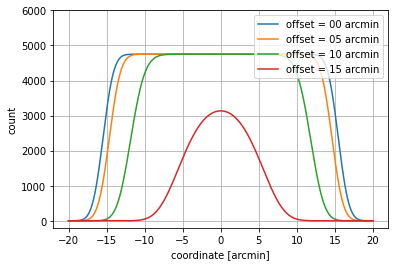

In [8]:
count = {}
x = np.linspace(-20, 20, 1000)
for key, offset in offset_dict.items():
    count[key] = [conv_2d(x, offset) for x in x]
[plt.plot(x, count, label=f"offset = {offset} arcmin") for offset, count in count.items()]
plt.xlabel("coordinate [arcmin]")
plt.ylabel("count")
plt.ylim([-200, 6000])
plt.grid()
plt.legend(loc=1)
# plt.savefig(f"sim_moon_observed_p{phase:02d}_t{tilt:03d}.pdf")

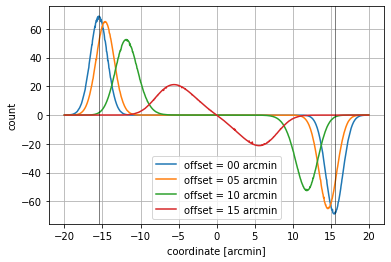

In [9]:
d_count = {}
for key in offset_dict.keys():
    d_count[key] = [count[key][i+1] - count[key][i] for i in range(999)]
x = np.linspace(-20, 20, 999)
[plt.plot(x, dcount, label=f"offset = {offset} arcmin") for offset, dcount in d_count.items()]
plt.xlabel("coordinate [arcmin]")
plt.ylabel("count")
plt.axvline(x=-15.5, c='black', lw=0.5)
plt.axvline(x=15.5, c='black', lw=0.5)
plt.grid()
plt.legend()
# plt.savefig(f"sim_moon_derivative_p{phase:02d}_t{tilt:03d}.pdf")

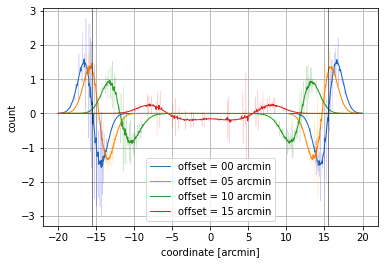

In [10]:
dd_count, dd_cor = {}, {}
x = np.linspace(-20, 20, 998)
v = np.ones(10)/10.0
for key in offset_dict.keys():
    dd_count[key] = [d_count[key][i+1] - d_count[key][i] for i in range(998)]
    dd_cor[key] = np.convolve(dd_count[key], v, mode='same')
[plt.plot(x, dcount, lw=1, alpha=1, label=f"offset = {val} arcmin") for val, dcount in dd_cor.items()]
[plt.plot(x, dcount, lw=0.5, color=color, alpha=0.2) for (val, dcount), color in zip(dd_count.items(), ['blue', 'orange', 'green', 'red'])]
plt.xlabel("coordinate [arcmin]")
plt.ylabel("count")
plt.axvline(x=-15.5, c='black', lw=0.5)
plt.axvline(x=15.5, c='black', lw=0.5)
plt.grid()
plt.legend()
# plt.savefig(f"sim_moon_dderivative_p{phase:02d}_t{tilt:03d}.pdf")

In [11]:
def gaussian_func(x, b, c, a):
    return a * np.exp( - (x - b)**2 / (2 * c**2))
x = np.linspace(-20,0,500)
ini = {}
for key in offset_dict.keys():
    ini[key] = (-16*np.sqrt(1-pos**2/16**2), 2, 100)
popt, pcov = {}, {}
for key in offset_dict.keys():
    popt[key], pcov[key] = curve_fit(gaussian_func, x, d_count[key][:500], p0=ini[key])
print(popt['10'], ini['10'], popt['00'], ini['00'])

NameError: name 'pos' is not defined

FWHM =  -0.34522794610208585 arcmin  for offset = 0 arcmin
FWHM =  -0.0018472908929401959 arcmin  for offset = 5 arcmin
FWHM =  0.4913366636187807 arcmin  for offset = 10 arcmin
FWHM =  5.609541486227144 arcmin  for offset = 15 arcmin


[None, None, None, None]

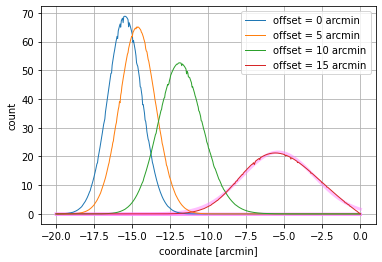

In [18]:
x = np.linspace(-20,0,500)
estimated_curve = {}
for key in offset_dict.keys():
    estimated_curve[key] = gaussian_func(x, popt[key][0], popt[key][1], popt[key][2])
[plt.plot(x, estimated_curve[key], color=(1, 0.5, 1), lw=3, alpha=0.5) for key in offset_dict.keys()]
[plt.plot(x, d_count[key][:500], lw=1, label=f"offset = {offset} arcmin") for key, offset in offset_dict.items()]
plt.xlabel("coordinate [arcmin]")
plt.ylabel("count")
plt.grid()
plt.legend()
[print("FWHM = ", 2*popt[key][1]*np.sqrt(2*np.log(2)), f"arcmin  for offset = {offset} arcmin") for key, offset in offset_dict.items()]
# plt.savefig(f"sim_moon_fit_p{phase:02d}_t{tilt:03d}.pdf")